# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [134]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

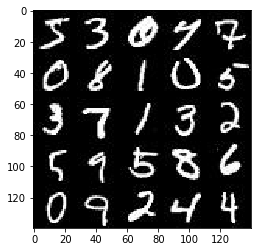

In [207]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import pickle as pkl

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

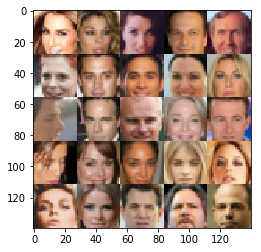

In [136]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [137]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [165]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
    input_z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learn_rate = tf.placeholder(tf.float32,name='learn_rate')
    return (input_real,input_z,learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [166]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    print('Disc. Input Shape: ',images.get_shape().as_list())
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        images = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        images = tf.maximum(alpha*images,images)
        
        cnv_lyr_depth = 128
        while(cnv_lyr_depth<512):
            images = tf.layers.conv2d(images,cnv_lyr_depth,5,strides=2,padding='same')
            images = tf.layers.batch_normalization(images,training=True)
            images = tf.maximum(alpha*images,images)
            print('Disc. image shape: ',images.get_shape().as_list())
            cnv_lyr_depth = int(cnv_lyr_depth*2)
        
        flat = tf.reshape(images,(-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        output = tf.sigmoid(logits)

    return (output,logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Disc. Input Shape:  [None, 28, 28, 3]
Disc. image shape:  [None, 7, 7, 128]
Disc. image shape:  [None, 4, 4, 256]
Disc. Input Shape:  [None, 28, 28, 3]
Disc. image shape:  [None, 7, 7, 128]
Disc. image shape:  [None, 4, 4, 256]
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [185]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    print('Gen. Input image shape: ',z.get_shape().as_list())
    with tf.variable_scope('generator', reuse = not is_train):
        images = tf.layers.dense(z,(7*7*256))
        images = tf.reshape(images,(-1,7,7,256))
        images = tf.layers.batch_normalization(images,training=is_train)
        images = tf.maximum(alpha*images,images)
        print('Gen. image shape: ',images.get_shape().as_list())
        cnv_lyr_depth = 128
        while(cnv_lyr_depth>64):
            images = tf.layers.conv2d_transpose(images,cnv_lyr_depth,5,strides=2,padding='same')
            images = tf.layers.batch_normalization(images,training=is_train)
            images = tf.maximum(alpha*images,images)
            print('Gen. image shape: ',images.get_shape().as_list())
            cnv_lyr_depth = int(cnv_lyr_depth/2)
        
        
        logits = tf.layers.conv2d_transpose(images,out_channel_dim,5,strides=2,padding='same')
        print('Gen. image shape: ',logits.get_shape().as_list())
        #logits = tf.reshape(logits,(-1,28,28,out_channel_dim))
        output = tf.tanh(logits)      
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Gen. Input image shape:  [None, 100]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 5]
Gen. Input image shape:  [None, 100]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 5]
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [186]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    d_out_real, d_logits_real = discriminator(input_real)
    d_out_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_out_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_out_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_out_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss,g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Gen. Input image shape:  [None, 100]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 4]
Disc. Input Shape:  [None, 28, 28, 4]
Disc. image shape:  [None, 7, 7, 128]
Disc. image shape:  [None, 4, 4, 256]
Disc. Input Shape:  [None, 28, 28, 4]
Disc. image shape:  [None, 7, 7, 128]
Disc. image shape:  [None, 4, 4, 256]
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [187]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [188]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [208]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    samples, losses = [], []
    steps = 0
    print_every=10
    show_every=100
    figsize=(5,5)
    first_pass = True
    
    # Inputs
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # Loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    # Optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images*2
                # TODO: Train Model
                steps +=1
                
                #Step 1. Random Noise to feed into G
                batch_z = np.random.uniform(-1, 1, size=(batch_size,z_dim))
                
                #Step 2. Run Optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real: batch_images, learn_rate:learning_rate})
                              
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    show_generator_output(sess,16,input_z,data_shape[3],data_image_mode)
                else if first_pass:
                    show_generator_output(sess,16,input_z,data_shape[3],data_image_mode)
                    first_pass=False
        #saver = tf.train.Saver()
        #saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    with open('losses.pkl', 'wb') as f:
        pkl.dump(losses, f)
    
    return 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Now entering MNIST testing
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]
Disc. Input Shape:  [None, 28, 28, 1]
Disc. image shape:  [None, 7, 7, 128]
Disc. image shape:  [None, 4, 4, 256]
Disc. Input Shape:  [None, 28, 28, 1]
Disc. image shape:  [None, 7, 7, 128]
Disc. image shape:  [None, 4, 4, 256]
Epoch 1/2... Discriminator Loss: 0.1521... Generator Loss: 7.5803
Epoch 1/2... Discriminator Loss: 4.1492... Generator Loss: 0.3488
Epoch 1/2... Discriminator Loss: 1.5066... Generator Loss: 1.5379
Epoch 1/2... Discriminator Loss: 2.3116... Generator Loss: 2.3098
Epoch 1/2... Discriminator Loss: 2.4207... Generator Loss: 2.8218
Epoch 1/2... Discriminator Loss: 2.1707... Generator Loss: 1.9132
Epoch 1/2... Discriminator Loss: 1.4771... Generator Loss: 1.9815
Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 1.3030
Epoch 1/2... Discriminator Loss: 1.3271... Generator Loss: 1.1607
E

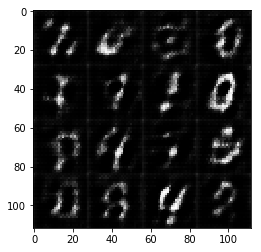

Epoch 1/2... Discriminator Loss: 1.7438... Generator Loss: 0.9813
Epoch 1/2... Discriminator Loss: 1.6074... Generator Loss: 1.3987
Epoch 1/2... Discriminator Loss: 1.8852... Generator Loss: 1.2191
Epoch 1/2... Discriminator Loss: 2.2295... Generator Loss: 0.1487
Epoch 1/2... Discriminator Loss: 1.7031... Generator Loss: 0.2765
Epoch 1/2... Discriminator Loss: 1.6589... Generator Loss: 0.9850
Epoch 1/2... Discriminator Loss: 1.6764... Generator Loss: 0.3177
Epoch 1/2... Discriminator Loss: 1.9488... Generator Loss: 0.2096
Epoch 1/2... Discriminator Loss: 1.8485... Generator Loss: 0.2423
Epoch 1/2... Discriminator Loss: 1.3782... Generator Loss: 0.5301
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]


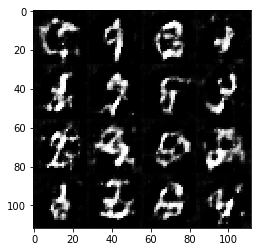

Epoch 1/2... Discriminator Loss: 1.3952... Generator Loss: 1.0026
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 1.2281
Epoch 1/2... Discriminator Loss: 1.5022... Generator Loss: 1.4277
Epoch 1/2... Discriminator Loss: 1.1162... Generator Loss: 1.0350
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 1.0582
Epoch 1/2... Discriminator Loss: 1.2349... Generator Loss: 0.8285
Epoch 1/2... Discriminator Loss: 1.0455... Generator Loss: 1.0333
Epoch 1/2... Discriminator Loss: 1.6018... Generator Loss: 1.6253
Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 1.3958
Epoch 1/2... Discriminator Loss: 1.3732... Generator Loss: 0.5257
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]


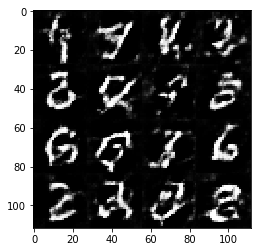

Epoch 1/2... Discriminator Loss: 0.9950... Generator Loss: 1.0362
Epoch 1/2... Discriminator Loss: 1.3204... Generator Loss: 1.3710
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 1.3245
Epoch 1/2... Discriminator Loss: 1.4943... Generator Loss: 0.8812
Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 1.0626
Epoch 1/2... Discriminator Loss: 1.6235... Generator Loss: 1.1485
Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 1.0941
Epoch 1/2... Discriminator Loss: 1.2574... Generator Loss: 1.0328
Epoch 1/2... Discriminator Loss: 1.3090... Generator Loss: 0.7621
Epoch 1/2... Discriminator Loss: 1.9537... Generator Loss: 0.2054
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]


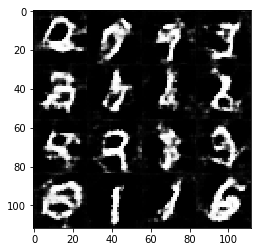

Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.6490
Epoch 1/2... Discriminator Loss: 1.1028... Generator Loss: 0.7673
Epoch 1/2... Discriminator Loss: 1.7703... Generator Loss: 1.8637
Epoch 1/2... Discriminator Loss: 1.2590... Generator Loss: 0.6344
Epoch 1/2... Discriminator Loss: 1.9213... Generator Loss: 0.2209
Epoch 1/2... Discriminator Loss: 1.5419... Generator Loss: 0.3376
Epoch 2/2... Discriminator Loss: 1.5856... Generator Loss: 0.3255
Epoch 2/2... Discriminator Loss: 1.2186... Generator Loss: 0.8879
Epoch 2/2... Discriminator Loss: 1.8560... Generator Loss: 0.2355
Epoch 2/2... Discriminator Loss: 1.5796... Generator Loss: 0.3703
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]


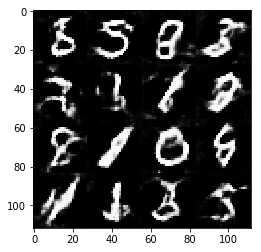

Epoch 2/2... Discriminator Loss: 2.1435... Generator Loss: 0.2083
Epoch 2/2... Discriminator Loss: 2.1981... Generator Loss: 0.1826
Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 0.5995
Epoch 2/2... Discriminator Loss: 2.0713... Generator Loss: 0.2168
Epoch 2/2... Discriminator Loss: 1.1657... Generator Loss: 0.8209
Epoch 2/2... Discriminator Loss: 1.0559... Generator Loss: 0.8161
Epoch 2/2... Discriminator Loss: 1.2691... Generator Loss: 0.5630
Epoch 2/2... Discriminator Loss: 1.4309... Generator Loss: 1.5799
Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.4858
Epoch 2/2... Discriminator Loss: 1.8496... Generator Loss: 0.2616
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]


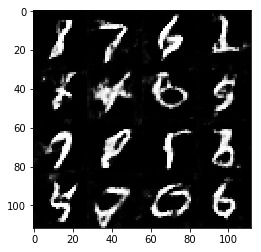

Epoch 2/2... Discriminator Loss: 2.5677... Generator Loss: 0.1141
Epoch 2/2... Discriminator Loss: 1.3156... Generator Loss: 0.5275
Epoch 2/2... Discriminator Loss: 1.6682... Generator Loss: 0.3576
Epoch 2/2... Discriminator Loss: 1.7937... Generator Loss: 0.2780
Epoch 2/2... Discriminator Loss: 1.1183... Generator Loss: 0.8104
Epoch 2/2... Discriminator Loss: 1.3182... Generator Loss: 0.6456
Epoch 2/2... Discriminator Loss: 2.0853... Generator Loss: 0.2107
Epoch 2/2... Discriminator Loss: 1.6538... Generator Loss: 0.3117
Epoch 2/2... Discriminator Loss: 1.0661... Generator Loss: 0.9816
Epoch 2/2... Discriminator Loss: 1.9136... Generator Loss: 0.2505
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]


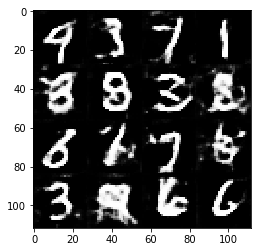

Epoch 2/2... Discriminator Loss: 1.5246... Generator Loss: 0.4088
Epoch 2/2... Discriminator Loss: 1.0097... Generator Loss: 0.8117
Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 0.9619
Epoch 2/2... Discriminator Loss: 1.0491... Generator Loss: 1.0149
Epoch 2/2... Discriminator Loss: 1.7583... Generator Loss: 2.4127
Epoch 2/2... Discriminator Loss: 1.1159... Generator Loss: 0.6543
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.5064
Epoch 2/2... Discriminator Loss: 1.7792... Generator Loss: 0.3613
Epoch 2/2... Discriminator Loss: 1.5243... Generator Loss: 0.3783
Epoch 2/2... Discriminator Loss: 1.1963... Generator Loss: 0.6285
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]


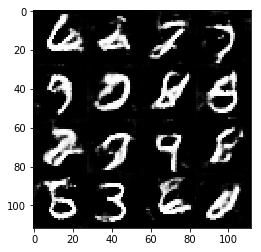

Epoch 2/2... Discriminator Loss: 1.1546... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.4616... Generator Loss: 0.4054
Epoch 2/2... Discriminator Loss: 1.5620... Generator Loss: 0.3643
Epoch 2/2... Discriminator Loss: 1.3497... Generator Loss: 1.8670
Epoch 2/2... Discriminator Loss: 1.4677... Generator Loss: 0.4041
Epoch 2/2... Discriminator Loss: 2.0497... Generator Loss: 0.2238
Epoch 2/2... Discriminator Loss: 0.9936... Generator Loss: 0.9569
Epoch 2/2... Discriminator Loss: 1.0023... Generator Loss: 1.0098
Epoch 2/2... Discriminator Loss: 0.8621... Generator Loss: 1.6325
Epoch 2/2... Discriminator Loss: 1.1162... Generator Loss: 0.7858
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 1]


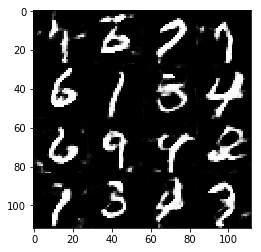

Epoch 2/2... Discriminator Loss: 1.7323... Generator Loss: 0.2796
Epoch 2/2... Discriminator Loss: 0.9412... Generator Loss: 1.4401
Epoch 2/2... Discriminator Loss: 1.0856... Generator Loss: 0.6967


In [212]:
batch_size = 128
z_dim = 400
learning_rate = 0.002
beta1 = 0.3
real_size = (28,28,3)
alpha = 0.2

print('Now entering MNIST testing')
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]
Disc. Input Shape:  [None, 28, 28, 3]
Disc. image shape:  [None, 7, 7, 128]
Disc. image shape:  [None, 4, 4, 256]
Disc. Input Shape:  [None, 28, 28, 3]
Disc. image shape:  [None, 7, 7, 128]
Disc. image shape:  [None, 4, 4, 256]
Epoch 1/1... Discriminator Loss: 2.0806... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 3.2341... Generator Loss: 0.1095
Epoch 1/1... Discriminator Loss: 2.4535... Generator Loss: 0.1463
Epoch 1/1... Discriminator Loss: 1.8168... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.6002... Generator Loss: 0.3554
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.3553
Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 0.3346
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.5894... Generator Loss: 2.3864
Epoch 1/1... Discriminator L

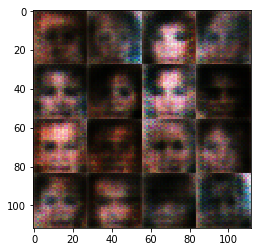

Epoch 1/1... Discriminator Loss: 2.7488... Generator Loss: 2.3702
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.3991
Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 1.7904
Epoch 1/1... Discriminator Loss: 1.8847... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.6421... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.6840... Generator Loss: 1.4112
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 1.5739... Generator Loss: 0.3273
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]


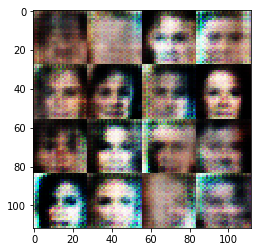

Epoch 1/1... Discriminator Loss: 2.9991... Generator Loss: 3.1667
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.5437... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 1.0540
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.5890... Generator Loss: 0.4756
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.6372
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]


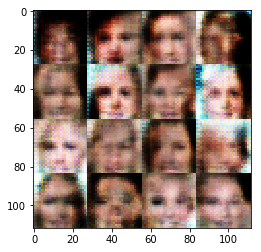

Epoch 1/1... Discriminator Loss: 0.5658... Generator Loss: 1.3090
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.1626
Epoch 1/1... Discriminator Loss: 0.8021... Generator Loss: 1.5057
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.4022
Epoch 1/1... Discriminator Loss: 1.6327... Generator Loss: 0.5414
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]


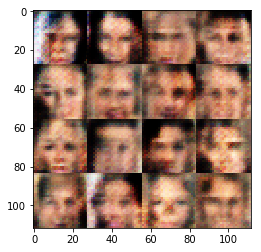

Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 2.0864... Generator Loss: 0.1827
Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 0.4050
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.3664
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 1.6770... Generator Loss: 1.3196
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 1.1971
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.6909
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]


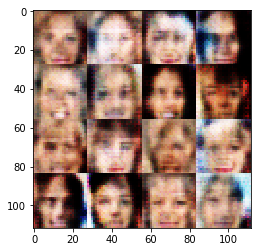

Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.8709... Generator Loss: 1.1945
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.5548
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]


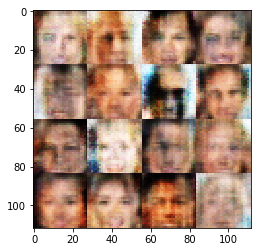

Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 1.0546
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.5647
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7004
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]


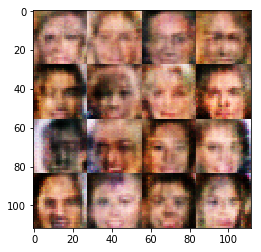

Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 1.1120
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.6385... Generator Loss: 0.3697
Epoch 1/1... Discriminator Loss: 1.5973... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.5898... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.5812... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.6002
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]


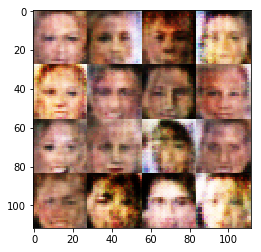

Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 1.3742
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 2.3421... Generator Loss: 0.1180
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 2.1759... Generator Loss: 0.1763
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6102
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]


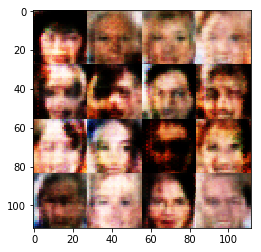

Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.4441
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.5405
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]


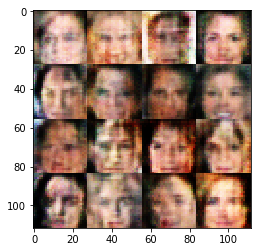

Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.5465... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.0247
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.7696
Epoch 1/1... Discriminator Loss: 0.3845... Generator Loss: 1.8935
Epoch 1/1... Discriminator Loss: 0.1149... Generator Loss: 2.7450
Epoch 1/1... Discriminator Loss: 0.0110... Generator Loss: 6.2074
Epoch 1/1... Discriminator Loss: 0.0089... Generator Loss: 5.6746
Epoch 1/1... Discriminator Loss: 0.0919... Generator Loss: 2.6824
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]


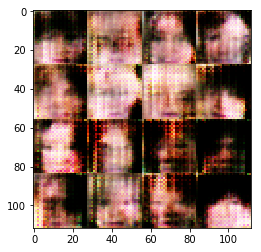

Epoch 1/1... Discriminator Loss: 0.0228... Generator Loss: 4.2555
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 7.3533
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.4901
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 1.0059
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]


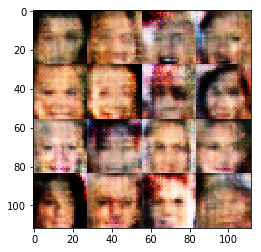

Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 1.1380
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.9172
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]


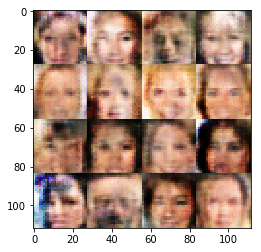

Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.5959... Generator Loss: 0.3704
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.4432
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.7215... Generator Loss: 0.3578
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.5504
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]


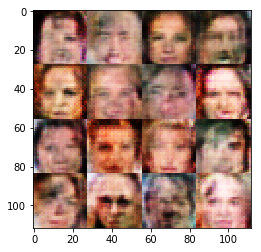

Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.6901
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]
Gen. Input image shape:  [None, 400]
Gen. image shape:  [None, 7, 7, 256]
Gen. image shape:  [None, 14, 14, 128]
Gen. image shape:  [None, 28, 28, 3]


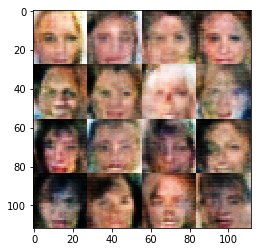

Epoch 1/1... Discriminator Loss: 2.2142... Generator Loss: 1.5933
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.2685
Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 0.7600... Generator Loss: 1.0488
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.4117
Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 0.3630... Generator Loss: 1.5609
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 1.6650


In [213]:
batch_size = 128
z_dim = 400
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.